In [0]:
import os
import shutil
import glob
import urllib.request
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf 
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from matplotlib import pyplot as plt #Ploting charts
from glob import glob #retriving an array of files in directories
from keras.models import Sequential #for neural network models
from keras.layers import Dense, Dropout, Flatten, ZeroPadding2D, Conv2D, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator #Data augmentation and preprocessing
from keras.utils import to_categorical #For One-hot Encoding
from keras.optimizers import Adam, SGD, RMSprop #For Optimizing the Neural Network
from keras.callbacks import EarlyStopping
from google.colab import auth
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
from tqdm import tqdm
from numpy import expand_dims
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.callbacks import EarlyStopping, ReduceLROnPlateau,ModelCheckpoint

Using TensorFlow backend.


In [0]:
a = []
while(1):
    a.append('1')

In [0]:
auth.authenticate_user()
gauth = GoogleAuth()


In [0]:
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
classes = ["NORMAL", "EMPHYSEMA"]
path_train = "/content/gdrive/My Drive/train"
path_val = "/content/gdrive/My Drive/val"
path_test = "/content/gdrive/My Drive/test"

train_data = glob(path_train+"/NORMAL/*.png")
train_data += glob(path_train+"/EMPHYSEMA/*.png")
data_gen = ImageDataGenerator(
    #samplewise_center=True, 
    #featurewise_center=True,
    brightness_range=[0.4,1.1],
    #samplewise_std_normalization=True, 
    horizontal_flip = True, 
    #vertical_flip = True, 
    #height_shift_range= 0.05, 
    width_shift_range=0.1, 
    rotation_range=20, 
    shear_range = 0.1,
    fill_mode = 'nearest',
    zoom_range=0.28)
data_gen1 = ImageDataGenerator() 

train_generator = data_gen.flow_from_directory(path_train, target_size = (210, 210), classes = classes, class_mode = "categorical")
val_generator = data_gen1.flow_from_directory(path_val, target_size = (210, 210), classes = classes, class_mode = "categorical")
test_generator = data_gen1.flow_from_directory(path_test, target_size = (210, 210), classes = classes, class_mode = "categorical")

Found 4066 images belonging to 2 classes.
Found 1160 images belonging to 2 classes.
Found 581 images belonging to 2 classes.


{'NORMAL': 0, 'EMPHYSEMA': 1}


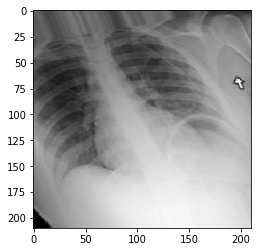

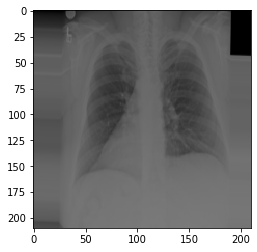

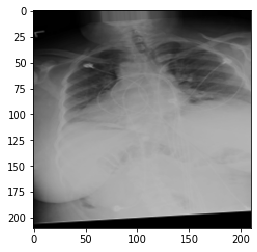

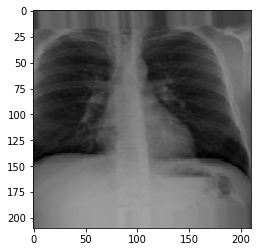

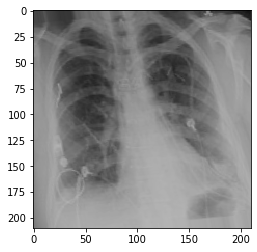

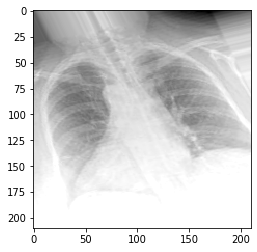

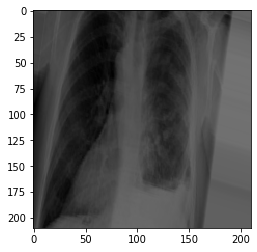

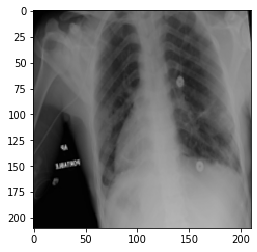

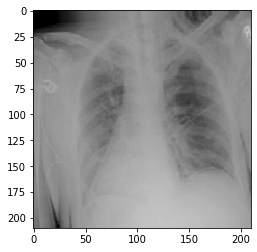

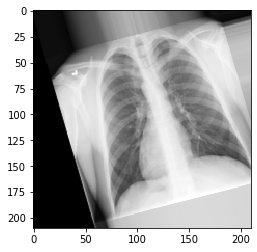

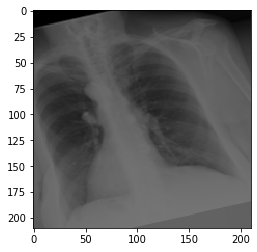

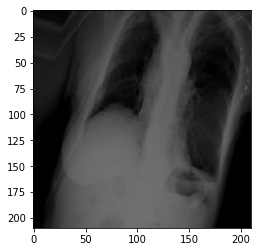

In [0]:
x, y = train_generator.next()
 
classes_val = val_generator.class_indices
print(classes_val)
idx=1
for i in range(12):     
    img = x[i]
    #print(y[i])
    plt.imshow(img.astype(np.uint8))
    plt.show()

In [0]:
x_train,y_train = train_generator.next()
x_val,y_val = val_generator.next()
x_test,y_test = test_generator.next()

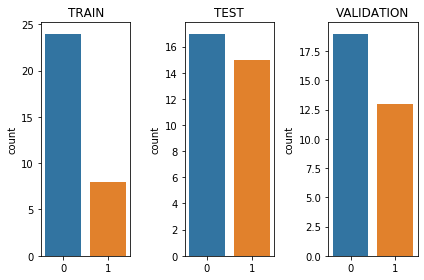

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns 

plt.subplot(1,3,1)
sns.countplot(np.argmax(y_train, axis=1)).set_title('TRAIN')

plt.subplot(1,3,2)
sns.countplot(np.argmax(y_test, axis=1)).set_title('TEST')

plt.subplot(1,3,3)
sns.countplot(np.argmax(y_val, axis=1)).set_title('VALIDATION')

plt.tight_layout()

(32, 210, 210, 3)


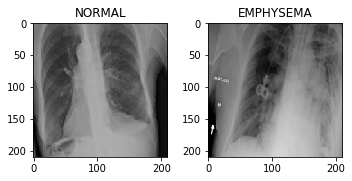

In [0]:
print(x_train.shape)

plt.figure(figsize=(5, 3))

y_train_classes = np.argmax(y_train, axis = 1)

plt.subplot(1,2,1).set_title('NORMAL')
plt.imshow(x_train[np.argmax(y_train_classes == 0)].astype(np.uint8))

plt.subplot(1,2,2).set_title('EMPHYSEMA')
plt.imshow(x_train[np.argmax(y_train_classes == 1)].astype(np.uint8))

plt.tight_layout()

In [0]:
import keras
from keras import backend as K
from keras.models import Model
from keras.layers.advanced_activations import LeakyReLU
from keras.layers import Flatten, Dense, BatchNormalization, Dropout, GlobalAveragePooling2D
from keras.applications.vgg16 import VGG16
#from keras.applications.vgg19 import VGG19
from keras.applications.densenet import DenseNet121
from keras.applications.inception_v3 import InceptionV3
from keras import optimizers
from keras import regularizers
from keras.callbacks import TensorBoard
from keras.callbacks import LearningRateScheduler


def step_decay_schedule(initial_lr=1e-4, decay_factor=0.75, step_size=30):
    def schedule(epoch):
         return initial_lr * (decay_factor ** np.floor(epoch/step_size))
        #  return (epoch/10) * 0.00001
    return LearningRateScheduler(schedule, verbose=1)

lrschedule = step_decay_schedule(initial_lr=1e-4, decay_factor=0.75, step_size=30)

batch_size=32
input_shape=(210,210,3)
filepath="/content/gdrive/My Drive/Colab Notebooks/EP:{epoch:03d}-TL:{loss:.3f}-TA:{acc:.3f}-VA:{val_acc:.3f}-VL:{val_loss:.3f}.hdf5"
model_checkpoint = ModelCheckpoint(filepath, save_best_only=True, monitor='val_acc', mode='max')
earlystop = EarlyStopping(patience=50,verbose=1,restore_best_weights=True)
#learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc',patience=1,verbose=1,factor=0.6,min_lr=0.00001)
tensorboard = TensorBoard(log_dir='/content/gdrive/My Drive/Graph', histogram_freq=0,  write_graph=True)
callbacks_fine = [model_checkpoint,lrschedule]
callbacks = [earlystop, model_checkpoint,tensorboard,lrschedule]


train_datagen = ImageDataGenerator(
    #samplewise_center=True,     
    #brightness_range=[0.2,0.8],
    #samplewise_std_normalization=True, 
    horizontal_flip = True, 
    #vertical_flip = True, 
    #height_shift_range= 0.05, 
    #width_shift_range=0.1, 
    rotation_range=50, 
    shear_range = 0.1,
    fill_mode = 'nearest',
    zoom_range=0.25,
    
)

from keras import applications
from keras.layers import Input
input_tensor = Input(shape=(210, 210, 3))


input_shape = (210, 210, 3)
init = 'glorot_uniform'
reg = regularizers.l2(0.0005)
strides=(1,1)
padding='same'
chanDim = -1



### model architecture design/selection
# create the base pre-trained model
base_model = DenseNet121(include_top = False, weights='imagenet')

# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dropout(0.5)(x)
x = Dense(1024)(x)
# and a logistic layer
predictions = Dense(2, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional DenseNet layers
for layer in base_model.layers:
    layer.trainable = False

# compile the model (should be done *after* setting layers to non-trainable)

#model training
adam = keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(optimizer= adam, loss='categorical_crossentropy', metrics=['accuracy'])

#plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)
#print(model.summary())

#opt = keras.optimizers.Adam(beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=1e-4)
#model.compile(loss=keras.losses.categorical_crossentropy, optimizer=opt, metrics=['accuracy'])
model.summary()

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
zero_padding2d_3 (ZeroPadding2D (None, None, None, 3 0           input_4[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, None, None, 6 9408        zero_padding2d_3[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, None, None, 6 256         conv1/conv[

In [0]:
batchS = 64
epochC = 25

#train_generator = train_datagen.flow(x_train, y_train, batch_size= batchS)


history = model.fit_generator(
                train_generator,
                steps_per_epoch=500,
                epochs=epochC,
                #validation_data=validation_generator,
                validation_data=val_generator,
                # shuffle=False,
                validation_steps=100,
                callbacks=callbacks_fine,
                verbose=1)

Epoch 1/25

Epoch 00001: LearningRateScheduler setting learning rate to 0.0001.
500/500 [==============================] - 244s 487ms/step - loss: 0.7630 - acc: 0.5905 - val_loss: 0.9883 - val_acc: 0.4806
Epoch 2/25

Epoch 00002: LearningRateScheduler setting learning rate to 0.0001.
500/500 [==============================] - 234s 468ms/step - loss: 0.7096 - acc: 0.6019 - val_loss: 1.4425 - val_acc: 0.5441
Epoch 3/25

Epoch 00003: LearningRateScheduler setting learning rate to 0.0001.
500/500 [==============================] - 235s 469ms/step - loss: 0.7053 - acc: 0.6109 - val_loss: 1.1525 - val_acc: 0.5659
Epoch 4/25

Epoch 00004: LearningRateScheduler setting learning rate to 0.0001.
500/500 [==============================] - 234s 467ms/step - loss: 0.6965 - acc: 0.6106 - val_loss: 4.5629 - val_acc: 0.4432
Epoch 5/25

Epoch 00005: LearningRateScheduler setting learning rate to 0.0001.
500/500 [==============================] - 235s 471ms/step - loss: 0.6955 - acc: 0.6152 - val_loss: 

In [0]:
for layer in base_model.layers[:110]:
  layer.trainable = True


#import tensorflow as tf
run_opts = tf.RunOptions(report_tensor_allocations_upon_oom = True)

# opt = keras.optimizers.Adam(lr=1e-5,beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=1e-4)
#opt = keras.optimizers.RMSprop(lr=1e-5, decay=1e-4, epsilon=1e-08)
opt = keras.optimizers.SGD(lr=0.045)
#opt = keras.optimizers.Adagrad(learning_rate=0.01)
#opt = keras.optimizers.Nadam(learning_rate=0.002, beta_1=0.9, beta_2=0.999)
#opt = keras.optimizers.Adadelta(learning_rate=1.0, rho=0.95)

"""
model.compile(loss='mean_squared_error', optimizer='sgd')
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
model.compile(loss='hinge', optimizer=opt, metrics=['accuracy'])
model.compile(loss='squared_hinge', optimizer=opt, metrics=['accuracy'])
"""
model.compile(loss=keras.losses.categorical_crossentropy, optimizer=opt, metrics=['accuracy'])
#base_model.summary()
model.summary()

batchS = 32
epochC = 100

callbacks = [model_checkpoint,tensorboard,lrschedule]


history = model.fit_generator(
                train_generator,
                steps_per_epoch=500,
                epochs=epochC,
                #validation_data=validation_generator,
                validation_data=val_generator,
                # shuffle=False,
                validation_steps=100,
                callbacks=callbacks,
                verbose=1)

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
zero_padding2d_3 (ZeroPadding2D (None, None, None, 3 0           input_4[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, None, None, 6 9408        zero_padding2d_3[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, None, None, 6 256         conv1/conv[0][0]                 
____________________________________________________________________________________________

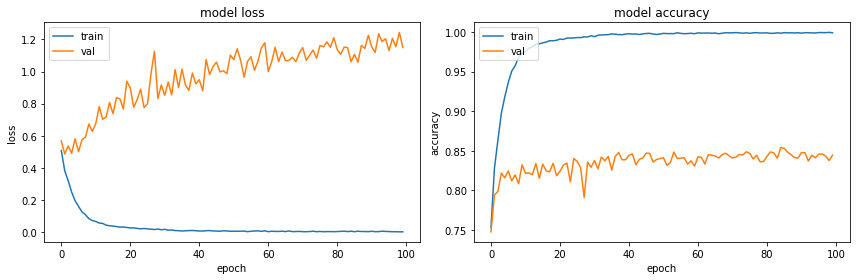

In [0]:
def plot_learning_curves(history):
    plt.figure(figsize=(12,4))
    
    plt.subplot(1,2,1)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    
    plt.subplot(1,2,2)
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    
    plt.tight_layout()
    
plot_learning_curves(history)





Model Loss: 0.8953580260276794, Accuracy: 0.9375


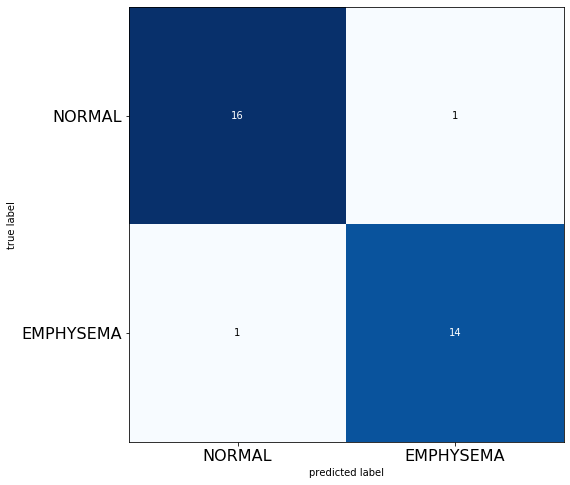

In [0]:
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

x_test,y_test = test_generator.next()

score = model.evaluate(x_test, y_test, verbose=0)
print('Model Loss: {}, Accuracy: {}'.format(score[0], score[1]))

y_pred = model.predict(x_test)
# to get the prediction, we pick the class with with the highest probability
y_pred_classes = np.argmax(y_pred, axis = 1) 
y_true = np.argmax(y_test, axis = 1) 

conf_mtx = confusion_matrix(y_true, y_pred_classes) 
plot_confusion_matrix(conf_mtx, figsize=(12,8), hide_ticks=True, cmap=plt.cm.Blues)
plt.xticks(range(2), ['NORMAL', 'EMPHYSEMA'], fontsize=16)
plt.yticks(range(2), ['NORMAL', 'EMPHYSEMA'], fontsize=16)
plt.show()





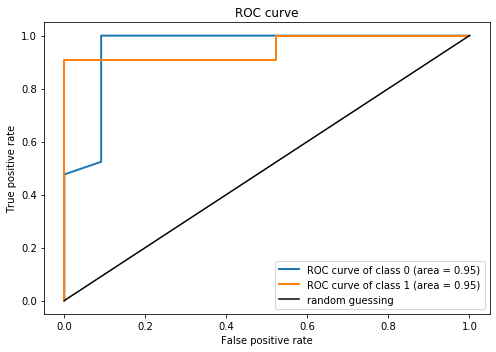

In [0]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
                                 
plt.figure(figsize=(7, 5))

for i in range(2):
    plt.plot(fpr[i], tpr[i], lw=2,
             label='ROC curve of class {0} (area = {1:0.3f})'.format(i, roc_auc[i]))
    
plt.plot(fpr[0], fpr[0], 'k-', label = 'random guessing')

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc="lower right")

plt.tight_layout()

In [0]:
import numpy as np
from scipy import interp
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn.metrics import roc_curve, auc

# Plot linewidth.
lw = 2
n_classes = 2

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(1,figsize = (35, 15))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=8,fontsize=35)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=8,fontsize=35)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]),fontsize=35,linewidth=8.0)

plt.plot([0, 1], [0, 1], 'k--', lw=lw,fontsize=35,linewidth=8.0)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic to two-class')
plt.legend(loc="lower right")

plt.show()


# Zoom in view of the upper left corner.
plt.figure(2,figsize = (35, 15))
plt.xlim(0, 0.2)
plt.ylim(0.8, 1)
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.3f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', fontsize=35,linewidth=8.0)


plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.3f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', fontsize=35,linewidth=8.0)


colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.3f})'
             ''.format(i, roc_auc[i]),fontsize=35,linewidth=8.0)



plt.plot([0, 1], [0, 1], 'k--', lw=lw,fontsize=35,linewidth=8.0)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

In [0]:
from sklearn.metrics import classification_report

y_pred = model.predict(x_test)
print(classification_report(y_true, y_pred))
